# Beginning Maps

---


### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd
from ipyleaflet import Map, GeoJSON, basemaps, basemap_to_tiles, Heatmap, Circle, LayerGroup, LayersControl, DOMWidget
import json
from matplotlib import pyplot as plt
from descartes import PolygonPatch

### Data

In [2]:
# Iowa City GeoJSON's

map_f = lambda f: '../data/maps/ic-{}.geojson'.format(f)
shapes = ['buildings', 'roads', 'water']
ic_geoms = {}

for i in shapes:
    with open(map_f(i)) as f:
        ic_geoms[i] = json.load(f)

In [3]:
# History points
def get_coords(df):
    """ Returns a list of lat, longs, and weights (1) from a location dataframe/table."""
    return list(zip(df.latitude, df.longitude, [1 for i in range(len(df))]))

coords_f = '../data/johnson-cnty-coords.csv'
coords_df = pd.read_csv(coords_f)

### Map - Base

In [5]:
bbox = {
    'top': 41.6883,
    'right': -91.4679,
    'bottom': 41.6077,
    'left': -91.6272
}

center = [
    (bbox['top']  + bbox['bottom']) / 2,
    (bbox['left'] + bbox['right']) / 2
]

zoom = 14

base = basemap_to_tiles(basemaps.Stamen.Toner)

#### Markers

<span style="color='red'">Note, this does not run fast ***at all***. We're keeping it here because it was used in the exploration.</span>

In [6]:
def create_circle_layer(df, radius):
    circles = [Circle(location=coord[0:2], radius=radius) for coord in get_coords(df.sample(1000))]
    return LayerGroup(layers=circles)
circle_layer = create_circle_layer(coords_df, 5)

#### Heat Map

Generate heatmaps using Leaflet

In [7]:
get_heat_map = lambda cmap: dict(zip([0.1, 0.25, 0.5, 0.75, 0.9], cmap))
yr_cmap  = {
    'junior':   get_heat_map(['#fee5d9','#fcae91','#fb6a4a','#de2d26','#a50f15']),
    'senior':   get_heat_map(['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c']),
    'postgrad': get_heat_map(['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c'])
}

def make_yr_heatmap(yr):
    yr_df = coords_df[coords_df['year'] == yr]
    gradient = yr_cmap[yr]
    heat = Heatmap(locations=get_coords(yr_df), radius=3, blur=3, gradient=gradient)
    heat_layer = LayerGroup(layers=[heat], name=yr)
    return heat_layer

heat_jr = make_yr_heatmap('junior')
heat_sr = make_yr_heatmap('senior')
heat_pg = make_yr_heatmap('postgrad')

In [9]:
M = Map(center=center, zoom=zoom)
controller = LayersControl()
M.add_control(controller)

M.add_layer(base)
#M.add_layer(data)

M.add_layer(heat_jr)
M.add_layer(heat_sr)
M.add_layer(heat_pg)

M

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Polygon Map w/ Matplotlib

In [10]:
class MatplotlibMap:
    def __init__(self, polygons=[]):
        self.polygons = []
        self.BLUE = '#6699cc'
        self.dark = '#333333'
        self.light= '#e8e8e8'
        
        self.add_polygons(polygons)
    
    def add_polygon(self, feature):
        geometry = feature['geometry']
        polygon  = PolygonPatch(geometry,
                                fc=self.light,
                                ec=self.dark,
                                alpha=1)
        self.polygons.append(polygon)
        
    def add_polygons(self, l):
        for poly in l:
            self.add_polygon(poly)
        
    def get_point_map(self, points, color='steelblue'):
        fig, axes = self.get_map()
        
        axes.scatter(
            x=points.longitude,
            y=points.latitude,
            s=10,
            alpha=0.1,
            c=points.year.apply(lambda x: yr_map[x]),
            zorder=2
        )
        
        return fig
    
    def get_map(self):
        fig = plt.figure(figsize=(15, 7))
        ax = fig.gca()
        for poly in self.polygons:
            ax.add_patch(poly)
        
        ax.axis('scaled')
        return fig, ax
    
yr_map = {
    'junior': '#fbb4ae',
    'senior': '#b3cde3',
    'postgrad': '#ccebc5',
    'none': 'steelblue'
}

All Years


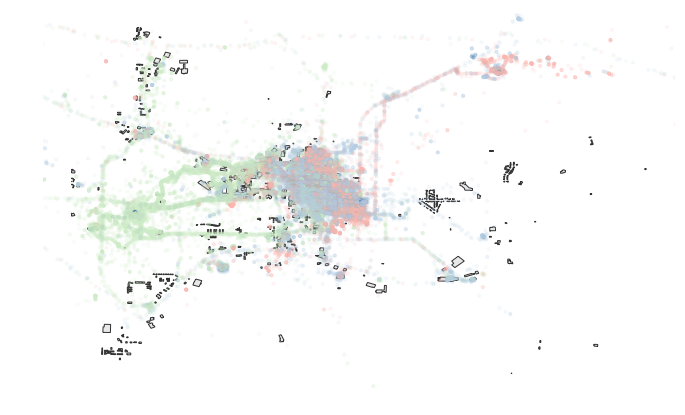

In [11]:
MM = MatplotlibMap(polygons=ic_geoms['buildings']['features'][::-1])
MM.get_point_map(coords_df)

print ('All Years')
plt.axis('off')
plt.show()

junior


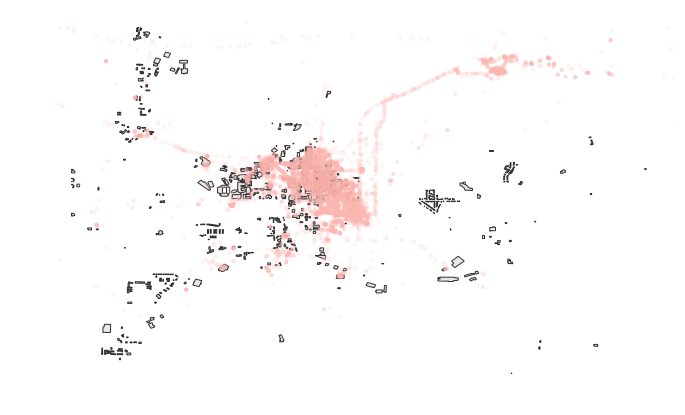

senior


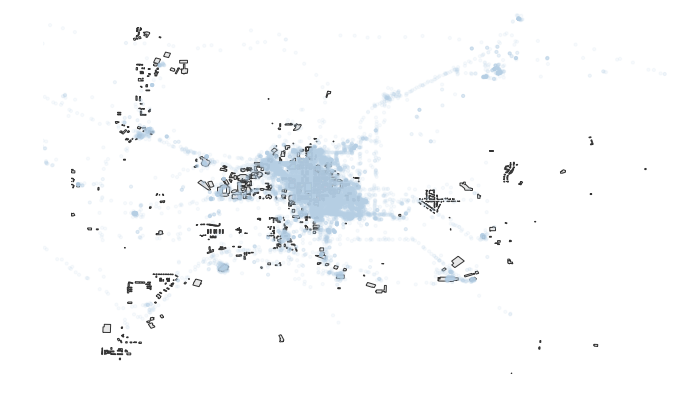

postgrad


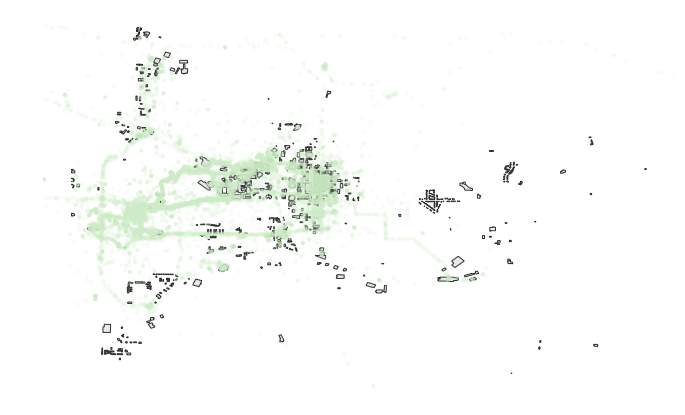

In [12]:
for yr in ['junior', 'senior', 'postgrad']:
    MM = MatplotlibMap(polygons=ic_geoms['buildings']['features'][::-1])
    
    yr_pts = coords_df[coords_df['year'] == yr]
    yr_color = yr_map[yr]
    
    fig = MM.get_point_map(yr_pts, yr_color)
    print (yr)
    plt.axis('off')
    plt.show()

### Mapping With GeoPandas / GeoJSON

In [42]:
ic_buildings = gpd.read_file(map_f('buildings'))
ic_roads = gpd.read_file(map_f('roads'))
ic_water = gpd.read_file(map_f('water'))

(-91.58503861778043, -91.46692489439138, 41.62116658, 41.69227542)

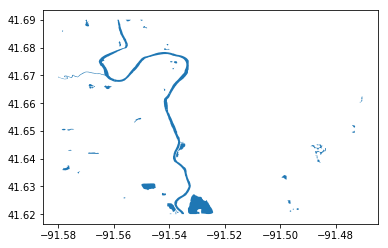

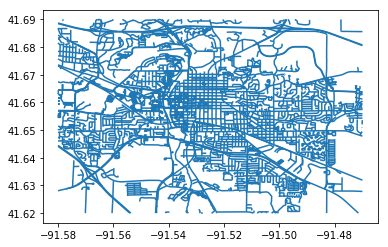

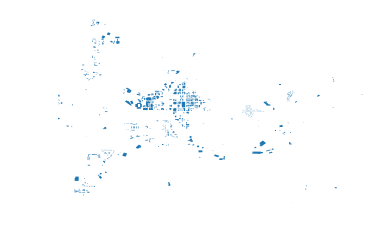

In [43]:
ic_water.plot()
ic_roads.plot()
ic_buildings.plot()
plt.axis('off')
#plt.show()

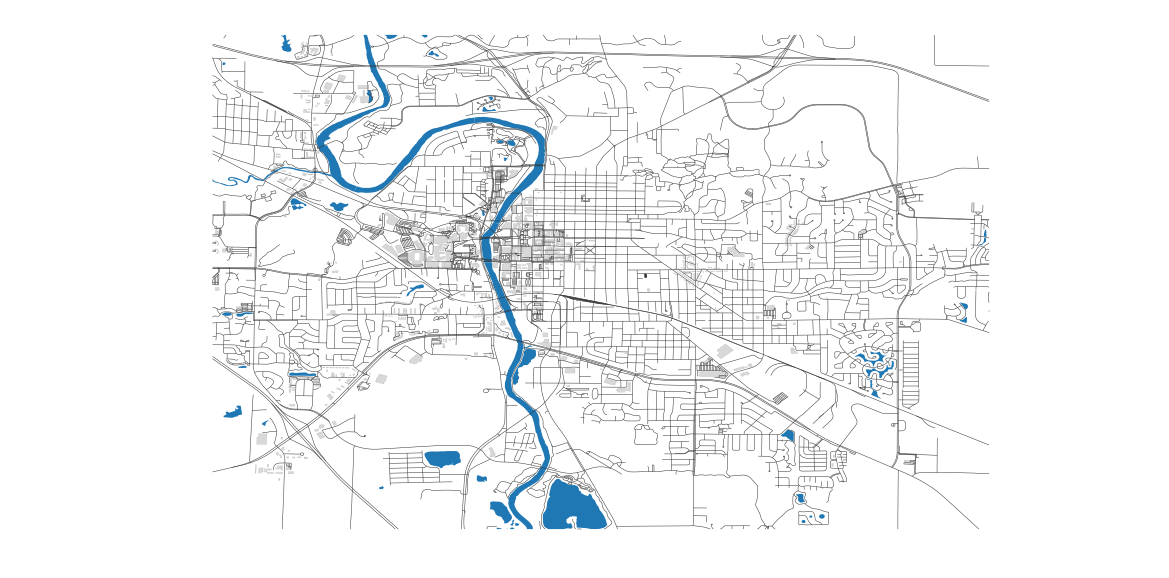

In [15]:
# Base map scratch
f, ax = plt.subplots(1, figsize=(20, 10))

for poly in ic_water['geometry']:
    gpd.plotting.plot_polygon_collection(geoms=poly, ax=ax)
    
for poly in ic_roads['geometry']:
    gpd.plotting.plot_linestring_collection(geoms=poly,
                                            ax=ax,
                                            linewidth=0.5,
                                            color='#333333'
                                           )
    
for poly in ic_buildings['geometry']:
    gpd.plotting.plot_polygon_collection(geoms=poly,
                                        ax=ax,
                                        color='#d8d8d8',
                                        linewidth=0.1,
                                        edgecolor='#666666'
                                        )
lims = plt.axis('equal')
ax.set_axis_off()
plt.show()

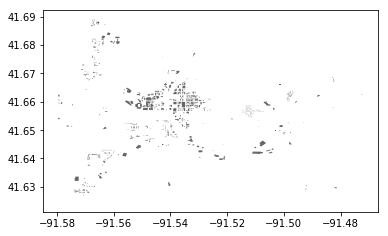

In [16]:
f, ax = plt.subplots(1)

ic_buildings.plot(ax=ax, color='#666666')

In [19]:
# For real
def gen_basemap(water, roads, buildings):
    # Get a figure and axes
    fig, axes = plt.subplots(1, figsize=(18, 12))
    
    water.plot(ax=axes,
               color='#9ecae1',
               edgecolor='#3182bd',
               linewidth=0.25)
    
    roads.plot(ax=axes,
               color='#333333',
               linewidth=0.5)
    
    buildings.plot(ax=axes,
                   color='#666666',
                   edgecolor='#333333',
                   linewidth=0.25)
    
    lims = plt.axis('equal')
    axes.set_axis_off()
    return fig, axes

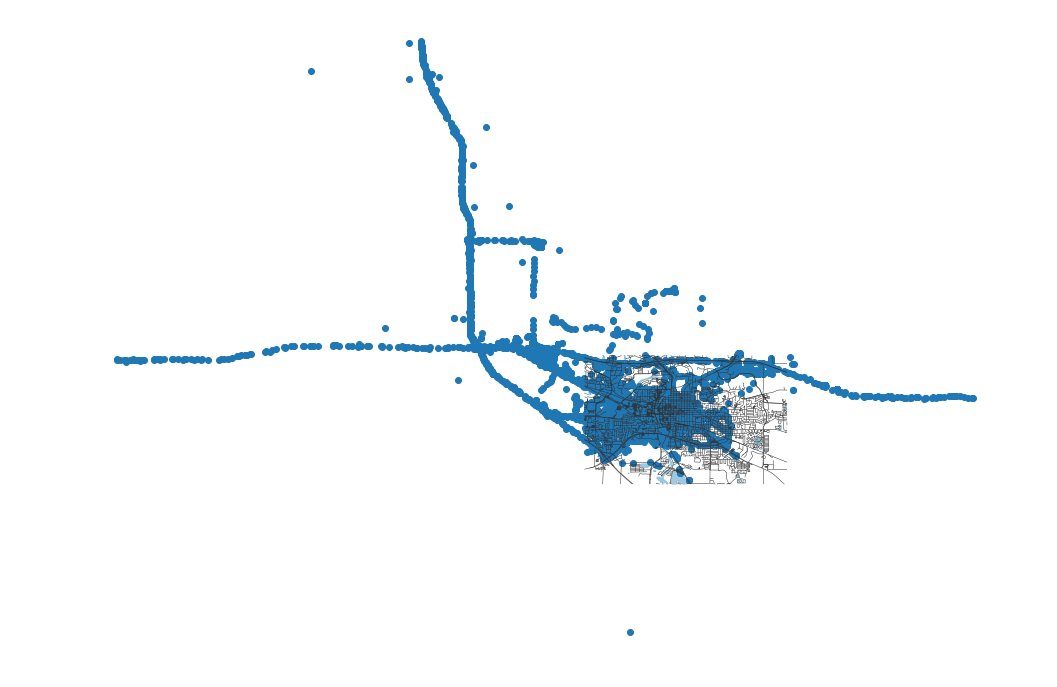

In [72]:
ic_map, ic_axes = gen_basemap(ic_water, ic_roads, ic_buildings)
ic_axes.scatter(x=coords_df.longitude, y=coords_df.latitude)
plt.show()

We're making better progress, but both our plots scales and our underlying data could be tidied up.

We're going to get two birds stoned at once, and combine our three GeoPandas dataframes together.

In [93]:
# create a gdf of all ic geoms
def gen_basedf(water, roads, buildings):
    # prepare dataframes
    water['class'] = 'water'
    roads['class'] = 'roads'
    buildings['class'] = 'buildings'
    
    base_cls= ['class', 'geometry']
    base_df = pd.concat([water[base_cls], roads[base_cls], buildings[base_cls]])
    base_gdf = gpd.GeoDataFrame(base_df)
    
    return base_df

def plot_basedf(df):
    fig, axes = plt.subplots(1, figsize=(18, 12))
    
    df[df['class'] == 'water'].plot(ax=axes,
                               color='#9ecae1',
                               edgecolor='#3182bd',
                               linewidth=0.25,
                                alpha=0.2)
    df[df['class'] == 'roads'].plot(ax=axes,
                                color='#333333',
                                linewidth=0.5)
    
    df[df['class'] == 'buildings'].plot(ax=axes,
                               color='#666666',
                               edgecolor='#333333',
                               linewidth=0.25)
    
    lims = plt.axis('equal')
    axes.set_axis_off()
    return fig, axes


def filter_df_bounds(ax, df):
    x_bounds = ax.get_xlim()
    y_bounds = ax.get_ylim()
    print (x_bounds, y_bounds)
    
    def inBounds(row):
        lat, lng = row['latitude'], row['longitude']
        x_good = (lng >= x_bounds[0]) and (lng <= x_bounds[1])
        y_good = (lat >= y_bounds[0]) and (lat <= y_bounds[1])
        return (x_good and y_good)
    
    df['within'] = df.apply(lambda x: inBounds(x), axis=1)
    keep_cols = ['timestamp', 'latitude', 'longitude', 'weekday', 'dayhour', 'year', 'business']
    
    return df[df['within'] == True][keep_cols]

In [86]:
print (len(coords_df))
test = filter_df_bounds(ic_ax, coords_df)
print (len(test))
test.head()

571882
(-91.5842798013245, -91.46572019867548) (41.616499999999995, 41.69350000000001)
569573


,timestamp,latitude,longitude,weekday,dayhour,year,business
0,2016-07-27 10:35:24-05:00,41.683614,-91.504861,Wednesday,10,none,True
1,2017-03-17 12:24:27-05:00,41.683686,-91.503358,Friday,12,senior,True
2,2016-07-27 10:37:24-05:00,41.683698,-91.504880,Wednesday,10,none,True
3,2016-07-27 10:38:25-05:00,41.683710,-91.504871,Wednesday,10,none,True
4,2016-07-27 10:28:39.467000-05:00,41.683757,-91.504225,Wednesday,10,none,True


In [70]:
ic_df = gen_basedf(ic_water, ic_roads, ic_buildings)
ic_df.head()

,class,geometry
0,water,"(POLYGON ((-91.55861183814891 41.69, -91.55811..."
1,water,"(POLYGON ((-91.5548454 41.681207, -91.5548752 ..."
2,water,"(POLYGON ((-91.5596 41.6685504, -91.5592917 41..."
3,water,"(POLYGON ((-91.5429001 41.6782948, -91.542687 ..."
4,water,"(POLYGON ((-91.5414825 41.657765, -91.54149270..."


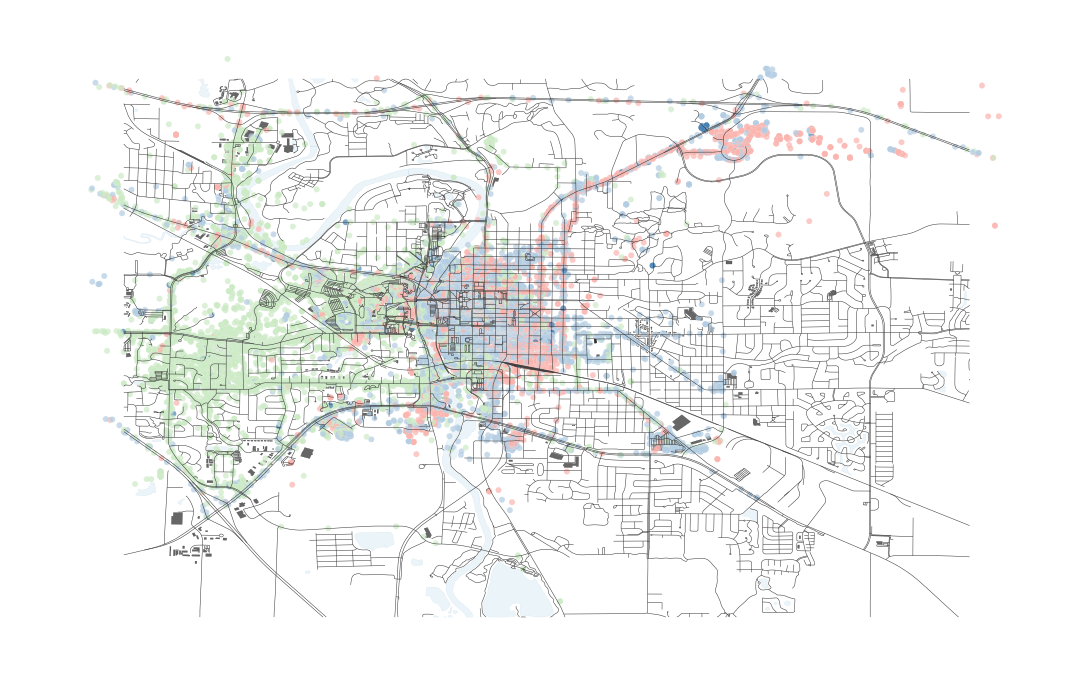

In [94]:
ic_map, ic_ax = plot_basedf(ic_df)
ic_ax.scatter(x=test.longitude, y=test.latitude,
              alpha=0.7,
              color=test.year.apply(lambda x: yr_map[x]),
              edgecolor='#ffffff',
              linewidth=0.1
             )
plt.show()

In [63]:
%run ./utils.py
geom_coords = convert_coords(coords_df)
geom_coords.head()

,timestamp,latitude,longitude,weekday,dayhour,weekend,year,business,coordinates
0,2016-07-27 10:35:24-05:00,41.683614,-91.504861,Wednesday,10,False,none,True,POINT (-91.50486120000001 41.6836137)
1,2017-03-17 12:24:27-05:00,41.683686,-91.503358,Friday,12,False,senior,True,POINT (-91.50335759999999 41.6836863)
2,2016-07-27 10:37:24-05:00,41.683698,-91.504880,Wednesday,10,False,none,True,POINT (-91.5048803 41.683698)
3,2016-07-27 10:38:25-05:00,41.683710,-91.504871,Wednesday,10,False,none,True,POINT (-91.5048714 41.6837105)
4,2016-07-27 10:28:39.467000-05:00,41.683757,-91.504225,Wednesday,10,False,none,True,POINT (-91.50422469999999 41.6837569)


### Where am I most likely to be from the hours of 8pm - 3am Thurs-Sun(roll over)?

In [99]:
q_days = set(['Thursday', 'Friday', 'Saturday', 'Sunday'])

def isGoingOut(row):
    """ 
    Thursday: hour > 8pm (20:00 // 19:00 [0 indexed])
    Friday: hour < 2 (3:00am 0 indexed) || hour > 19:00
    saturday: ^^
    sunday: hour < 2:00
    """
    day = row['weekday']
    hour = row['dayhour']
    
    if day not in q_days: return False
    else:
        if (day == 'Thursday'):
            return hour >= 19
        elif (day == 'Friday') or (day == 'Saturday'):
            return (hour <= 2) or (hour >= 19)
        elif (day == 'Sunday'):
            return hour <= 2
        else:
            return False
        
test['going_out'] = test.apply(lambda x: isGoingOut(x), axis=1)
going_out = test[test.going_out == True]
going_out.head()

,timestamp,latitude,longitude,weekday,dayhour,year,business,going_out
64,2017-06-09 20:03:23-05:00,41.687476,-91.514078,Friday,20,senior,False,True
1551,2017-06-09 20:02:19-05:00,41.687660,-91.499523,Friday,20,senior,False,True
2045,2017-06-09 20:01:15-05:00,41.681569,-91.508271,Friday,20,senior,False,True
2566,2017-10-13 21:16:14.476000-05:00,41.668449,-91.540101,Friday,21,postgrad,False,True
2567,2017-10-13 21:13:29.272000-05:00,41.668449,-91.540101,Friday,21,postgrad,False,True


In [100]:
print (len(geom_coords))
print (len(going_out))

571882
96822


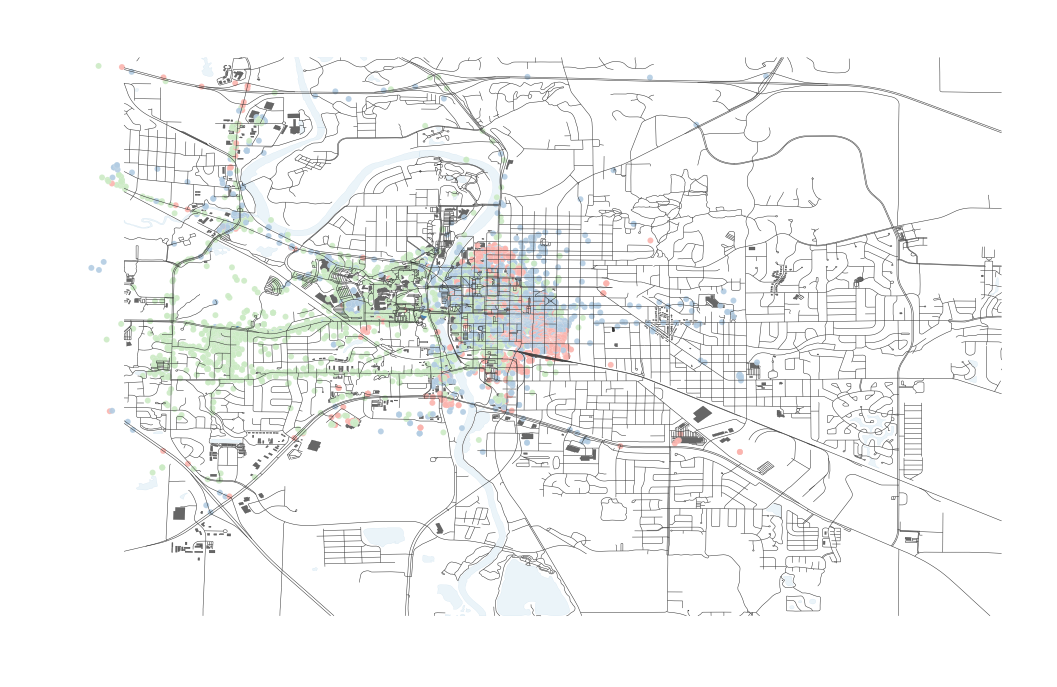

In [101]:
ic_map, ic_ax = plot_basedf(ic_df)
ic_ax.scatter(x=going_out.longitude, y=going_out.latitude,
              alpha=0.9,
              color=going_out.year.apply(lambda x: yr_map[x]),
              edgecolor='#ffffff',
              linewidth=0.1
             )
plt.show()